In [8]:
# 数据集特征
n_back = 200
n_out = 16
n_pre = n_out*15*2
n_feature = 2

train_day = 6
validation_day = 4
test_day = 3

# 神经网络参数
filters = [10, 15, 20]
kernel_size = [4, 6, 8]

# Preperation

In [40]:
from math import sqrt
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tcn.tcn import TCN
from keras.models import Sequential
from keras import layers
from sklearn.metrics import mean_squared_error

In [10]:
dataset = pd.read_csv('../wind_preprocessed.csv', header=0, index_col=0).query('day<13')

In [11]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [12]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [13]:
# 分割为训练集和测试集
values = reframed.values
n_train = train_day*24*60*2
n_validation = validation_day*24*60*2
n_test = test_day*24*60*2
train = values[:n_train, :]
validation = values[n_train:n_train+n_validation, :]
test = values[-n_test:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
validation_X, validation_y = validation[:, :n_obs], validation[:, -n_out:]
test_X, test_y = test[:, :n_obs], test[:, -n_out:]
# 重塑成3D格式 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
validation_X = validation_X.reshape((validation_X.shape[0], n_back, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
print(train_X.shape, train_y.shape)
print(validation_X.shape, validation_y.shape)
print(test_X.shape, test_y.shape)

(17280, 200, 2) (17280, 16)
(11520, 200, 2) (11520, 16)
(8640, 200, 2) (8640, 16)


# Testing

In [29]:
def plot_rmse(yreal, i, ax, test_y=test_y):
    rmse = np.std(yreal - test_y, axis = i)
    acc = (np.ones_like(rmse) - rmse)*100
    print('RMSE:', np.mean(rmse))
    print('Accuracy', np.mean(acc))
    if i==0:
        print('Evaluate By Day')
        t = np.arange(0, len(rmse), 1)
        ax.scatter(t, rmse, color = 'r', label='RMSE')
        ax.plot(t, rmse,"-",color='r', linewidth=1)
        ax.set_ylabel('RMSE')
        ax.legend(loc=6, fontsize=8)
        if i==0:
            ax.set_xlabel('Time/15min')
        ax_twin = ax.twinx()
        ax_twin.scatter(t,acc, label='Accuracy')
        ax_twin.plot(t, acc,"-", linewidth=1)
        ax_twin.set_ylabel('Accuracy(%)')
        
        ax_twin.legend(loc=7, fontsize=8)

    else:
        print('Evaluate By Sample')
        print(np.where(rmse==min(rmse)))
        t = np.arange(0, len(rmse), 1)
        ax.scatter(t, rmse, color = 'r', s=5)
        ax.plot(t, rmse,"-",color='r', linewidth=1)
        plt.axhline(0.15, 0, len(rmse), linestyle='--', color='grey')
        ax.set_ylabel('RMSE', fontsize=12)
        ax.set_xlabel('Test Samples', fontsize=12)
        ax.set_ylim(0, 0.3)
        ax.set_yticks(np.arange(0, 0.35, 0.05))
        ax.text(0, 0.25, 'Mean RMSE={:.1f}%'.format(np.mean(rmse)*100), fontsize=12)
    


def test_one(ypre, i, ax):
    # 随机指定test_X中的一个sample看预测效果
    yhat_i = ypre[i]
    yreal_i = test_y.reshape((len(test_y), n_out))[i]
    # 计算RMSE
    rmse = sqrt(mean_squared_error(yreal_i, yhat_i))
    # # 计算平均相对误差
    # sigma = np.mean((yhat_i - yreal_i) / yreal_i * 100)
    # ax = fig.subplots(2, 1)[0]
    t = np.arange(1, 17, 1)/4
    ax.scatter(t, yhat_i, label='predict', s=10)
    ax.scatter(t, yreal_i, label='real', s=10)
    ax.legend()
    ax.set_ylabel('Power')
    ax.set_xlabel('Time/h')
    ax.set_xticks(np.arange(0, 17, 2)/4)
    ax.text(0.1, 0.325, 'RMSE={:.1f}%'.format(rmse*100))

    # ax1 = fig.subplots(2, 1)[1]
    # t = np.arange(0, len(yhat_i), 1)
    # ax1.scatter(t, yhat_i-yreal_i, s=10)
    # ax1.set_xlabel('Time/15min')
    # ax1.set_ylabel('Residuals')

    # x = np.arange(0, 1, 0.1)
    # plt.plot(x, x, color='C1')
    # plt.scatter(yreal_i, yhat_i, s=10)
    # # plt.plot(yreal, yreal, color='C1')
    # plt.xlabel('real')
    # plt.ylabel('predict')
    # plt.gca().set_aspect(1)
    # plt.xlim(min(min(yreal_i), min(yhat_i))-0.01, max(max(yreal_i), max(yhat_i))+0.01)
    # plt.ylim(min(min(yreal_i), min(yhat_i))-0.01, max(max(yreal_i), max(yhat_i))+0.01)
    # plt.text(min(min(yreal_i), min(yhat_i)), max(max(yreal_i), max(yhat_i)), 'RMSE={:.2f}, Sigma={:.2f}'.format(rmse, sigma))


In [53]:
ypres = []
f = 20
for k in kernel_size:
    model = Sequential([
            layers.Input(shape=(train_X.shape[1], train_X.shape[2])),
            TCN(nb_filters=f, kernel_size=int(k), dilations=[1, 2, 4, 8]),
            layers.Dense(units=n_out)
        ])
    model.load_weights(f"tcn_{f}_{k}.h5")
    ypre = model.predict(test_X, verbose=1)
    ypres.append(ypre)

270/270 [==============================] - 7s 24ms/step


RMSE: 0.2003566
Accuracy 79.96434
Evaluate By Day
RMSE: 0.19916424
Accuracy 80.08358
Evaluate By Day
RMSE: 0.20689535
Accuracy 79.31047
Evaluate By Day


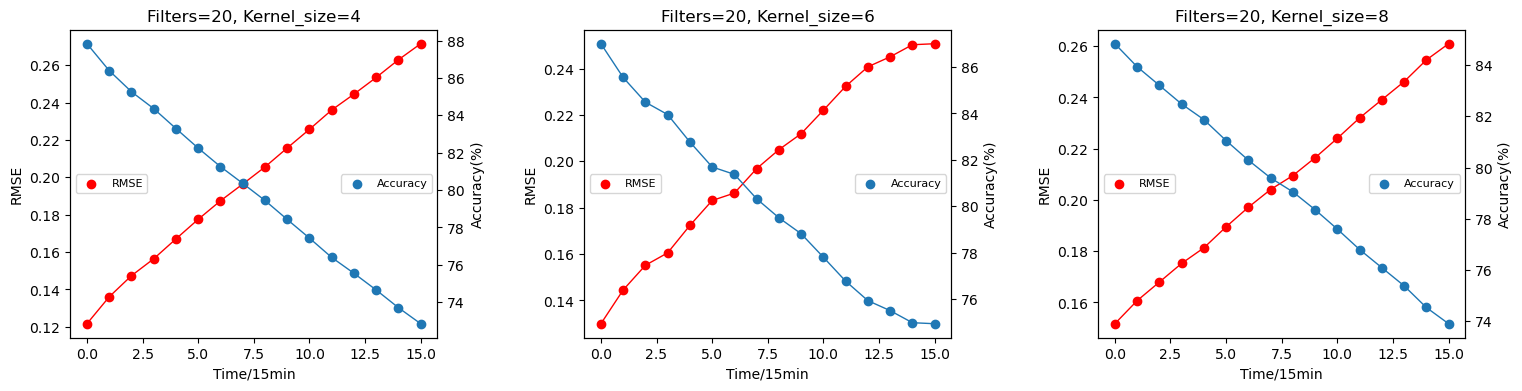

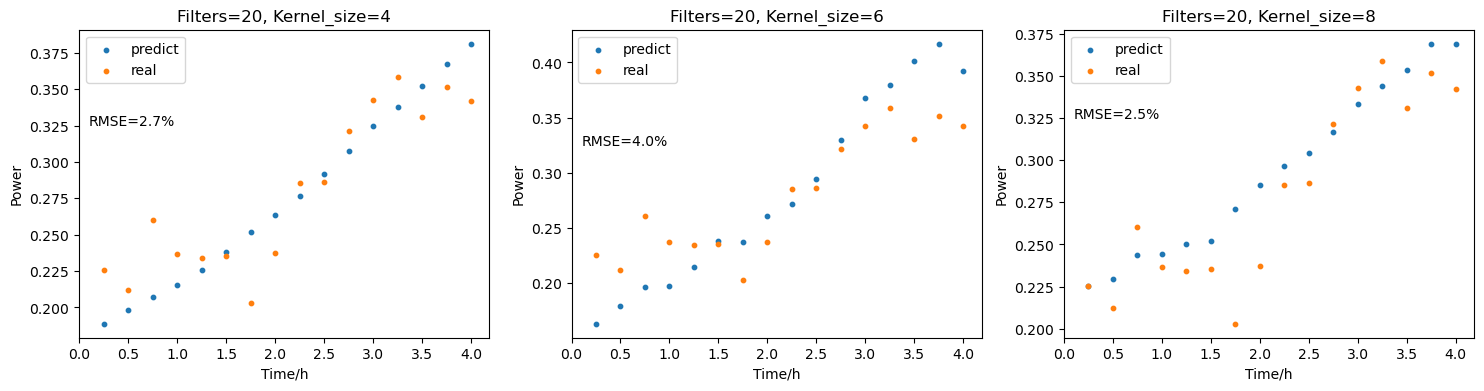

In [59]:
fig = plt.figure(figsize=(18, 4))
for i,y in enumerate(ypres):
    ax = fig.add_subplot(1, 3, i+1)
    plot_rmse(y, 0, ax)
    ax.set_title(f'Filters={f}, Kernel_size={kernel_size[i]}')
plt.subplots_adjust(wspace=0.4)

fig = plt.figure(figsize=(18, 4))
ind = 500
for i,y in enumerate(ypres):
    ax = fig.add_subplot(1, 3, i+1)
    test_one(y, ind, ax)
    ax.set_title(f'Filters={f}, Kernel_size={kernel_size[i]}')
plt.subplots_adjust(hspace=0.3)
plt.show()

In [135]:
ypres = []
k = 8
for f in filters:
    model = Sequential([
            layers.Input(shape=(train_X.shape[1], train_X.shape[2])),
            TCN(nb_filters=f, kernel_size=int(k), dilations=[1, 2, 4, 8]),
            layers.Dense(units=n_out)
        ])
    model.load_weights(f"tcn_{f}_{k}.h5")
    ypre = model.predict(test_X, verbose=1)
    ypres.append(ypre)

270/270 [==============================] - 6s 21ms/step


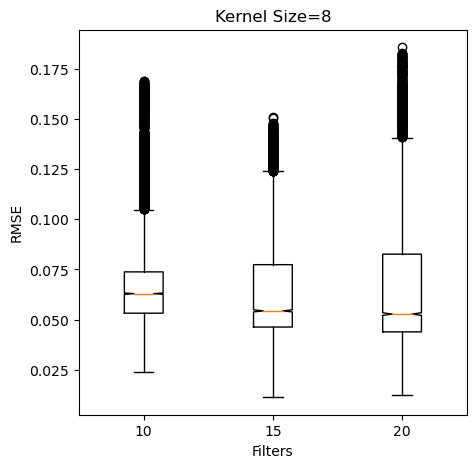

In [141]:
fig,ax = plt.subplots(figsize=(5, 5))
rmses = []
for i,y in enumerate(ypres):
    rmse = np.std(y - test_y, axis = 1)
    rmses.append(rmse)
ax.boxplot(rmses, notch=True)
ax.set_xlabel('Filters')
ax.set_ylabel('RMSE')
ax.set_title(f'Kernel Size={k}')
ax.set_xticklabels(filters)
plt.show()

## History

In [137]:
# def plot_history(f, k, ax):
#     with open(f'tcn_{f}_{k}_hist.pickle', 'rb') as file:
#         history = pickle.load(file)
#     ax.plot(history['loss'], label='train', c='red')
#     ax.plot(history['val_loss'], label='validation', c='blue')
#     ax.set_title('Filters={}, Kernel_size={}'.format(f, k))
#     ax.set_xlabel('Epcohs')
#     ax.set_ylabel('Loss Function (RMSE)')
#     plt.legend()

In [138]:
# fig = plt.figure(figsize=(15, 3))
# f = 10
# for i,k in enumerate(kernel_size):
#     ax = fig.add_subplot(1, 3, i+1)
#     plot_history(f, k, ax)

# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# # fig.suptitle('T Loss Function over Training')
# plt.show()

In [139]:
# fig = plt.figure(figsize=(15, 3))
# f = 15
# for i,k in enumerate(kernel_size):
#     ax = fig.add_subplot(1, 3, i+1)
#     plot_history(f, k, ax)

# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# # fig.suptitle('T Loss Function over Training')
# plt.show()

In [140]:
# fig = plt.figure(figsize=(15, 3))
# f = 20
# for i,k in enumerate(kernel_size):
#     ax = fig.add_subplot(1, 3, i+1)
#     plot_history(f, k, ax)

# plt.subplots_adjust(hspace=0.5, wspace=0.5)
# # fig.suptitle('T Loss Function over Training')
# plt.show()